In [1]:
%pylab inline
import scipy.optimize as opt
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "0" 
from tardis import *
from scipy import sparse,ndimage

Populating the interactive namespace from numpy and matplotlib
Tensorflow Version:  1.15.0
Running TARDIS 2.1...


Using TensorFlow backend.


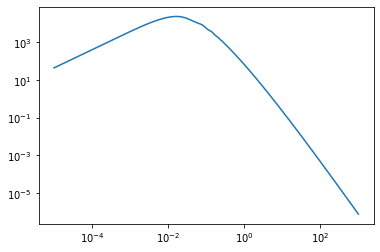

In [2]:
klin = np.loadtxt('F:/学习/天体物理/tardis-tf-master/data/Planck15_a1p00.txt').T[0]
plin = np.loadtxt('F:/学习/天体物理/tardis-tf-master/data/Planck15_a1p00.txt').T[1]

# plin[1300:1330] += 100
plt.loglog(klin,plin)
ipklin = iuspline(klin, plin)

In [3]:
n=64
uni = universe(bs=n, nc=n,z_f=2.0,ipklin = ipklin )
uni.evolv()

(64, 64, 64)
262144 65 262144
Total run time 8.498363733291626


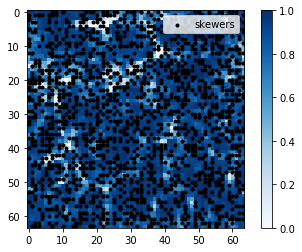

In [4]:
n_los = 2000
mock_lya = lya_survey(uni,10,10,sm=0.5,n_skewers=n_los)
mock_lya.select_skewers()
imshow(np.exp(-1*uni.final_tau_RSD[0,:,:,0]),cmap="Blues")
colorbar()
plt.scatter(mock_lya.skewers_fin[::n][:,0],mock_lya.skewers_fin[::n][:,1],color='k',marker='.',label='skewers')
legend(loc=1)

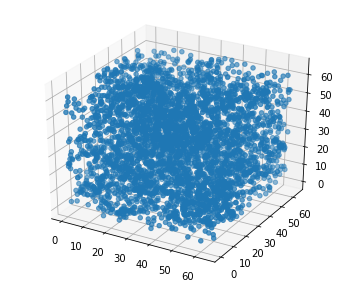

In [5]:
from mpl_toolkits.mplot3d import Axes3D
a = 8
mock_gal = gal_survey(uni,a*a) #inverse number density
mock_gal.select_galaxies() #selects galaxies

loc = mock_gal.samples_n #invidual Galaxy locations
fig=figure(figsize=(6,5))
ax1 = fig.add_subplot(111,projection='3d')
ax1.scatter(loc[:,0],loc[:,1],loc[:,2])

### Example copied from TARDIS.

In [34]:
tf.reset_default_graph()
lya=mock_lya
gal=mock_gal

xx = tf.placeholder(tf.float32, shape=(1, n, n, n)) #Starting Point
linear = tf.compat.v1.get_variable('linmesh', shape=(1, n, n, n),
                    initializer=tf.random_normal_initializer(mean=1.0, stddev=0.5), trainable=True)
initlin_op = linear.assign(xx, name='initlin_op')

starting_point = np.random.randn(1,n,n,n)

num_gal=gal.num_gal
yy_gal = tf.placeholder(tf.float32, [1, num_gal, 2]) #galaxy locations
yy_lya = tf.placeholder(tf.float32, [lya.skewers_fin.shape[0]]) #lya flux

Rs = tf.placeholder(tf.float64, shape = [1], name='smoothing')

def reduce_sum_det(x):
    #deterministic reduce sum
    v = tf.reshape(x, [1, -1])
    return tf.reshape(tf.matmul(v, tf.ones_like(v), transpose_b=True), [])
sum_op = reduce_sum_det

def likelihood_fn_specz(inputs, data):
    """ Evaluates the data chi-squared function
    """
    #Clipping very high values which end up dominating the likelihood
    data_clip = K.clip(data,-4,6)
    inputs_clip = K.clip(inputs,-4,6)
    residual = tf.subtract(inputs, data)
    #weighted by number count in bin for poisson errors
    values = -tf.multiply(tf.multiply(inputs_clip,data_clip),data_clip)

    return values

def likelihood_fn_lya(inputs, data, inverse_covar):
    """ Evaluates the data chi-squared function through Fast PM
    """
    #Clipping very high values which end up dominating the likelihood

    #weighted by number count in bin for poisson errors
    residual = tf.subtract(inputs, data)
    values = tf.multiply(residual, tf.transpose(tf.sparse.sparse_dense_matmul(inverse_covar, residual, adjoint_b=True)))

    return values

specz_likelihood = likelihood_fn_specz
evolved_field,evolved_state = uni.pm(linear)

In [35]:
zz = tf.Variable(gal.samples_n[:,2].reshape(1,-1,1).astype(np.float32), name="redshift", trainable=False) #Bias

galaxy_positions = tf.concat([yy_gal,zz],axis=2)

data = flowpm.cic_paint(tf.zeros_like(linear), galaxy_positions)

Rsm = tf.multiply(Rs, 1)

kvec = fftk((n,n,n), symmetric=False)
kmesh = sum((kk)**2 for kk in kvec)**0.5
pkmesh = ipklin(kmesh)

data_sm = smoothing(data,Rsm,kmesh,n)

likelihood_specz = specz_likelihood(evolved_field,data_sm)

gal_bias=[1.0,0.0]
bias_lya = tf.Variable([0.226,1.5], name="variables", trainable=False) #Bias
bias_galaxy = tf.Variable(gal_bias, name="variables", trainable=False) #Bias
state_l = flowpm.lpt_init(linear, a0=0.000001)
ic_den = flowpm.cic_paint(tf.zeros_like(linear),state_l[0])

RSD_gal,RSD_tau = uni.RSD(evolved_field,evolved_state,bias_galaxy,bias_lya,ic_den)      

evolved_field_FGPA = K.exp(-1.0*RSD_tau)#fgpa(self.evolved_field,bias_lya)
evolved_field_FGPA_sm = smoothing(evolved_field_FGPA,Rsm,kmesh,n)
flux_val = flowpm.cic_readout(evolved_field_FGPA_sm,np.array(lya.skewers_fin,dtype=np.float32).reshape(1,-1,3))

likelihood = likelihood_fn_lya(flux_val,yy_lya,lya.inverse_covar)
likelihood_lya = sum_op(likelihood)

post1 = sum_op(likelihood_specz)     
post2 = sum_op(likelihood_lya)
specz_fac = 0
lya_fac = 1.0

lineark = flowpm.utils.r2c3d(linear, norm=n**3)
priormesh = tf.square(tf.cast(tf.abs(lineark), tf.float32))
prior_1 = sum_op(tf.multiply(priormesh, 1./pkmesh**2))#*100000*8**3*2*2
prior_total = prior_1

logposterior = (post1/10.0*specz_fac + post2*10.0*lya_fac) + sum_op(prior_total)

pk_it = pk(tf.squeeze(linear,0),shape = linear.shape[1:], boxsize= np.array([n,n,n]),kmin=0.001,dk=uni.dk)

gtol=1e-5/512

sess = tf.Session()
sess.run(tf.compat.v1.global_variables_initializer())
sess.run(initlin_op, {xx:starting_point})
annel_steps = [3,2,1,0]
maxiter = [10,10,10,20]
for nn,r0 in enumerate(annel_steps):
    opt = ScipyOptimizerInterface(logposterior, var_list=[linear], method='L-BFGS-B',options={'maxiter': maxiter[nn], 'gtol':gtol,'disp': True})
    z = opt.minimize(sess, {yy_gal:gal.samples_n[:,:2].reshape(1,gal.num_gal,2),yy_lya:lya.vals_observed,Rs:[r0]})
recon_linear, recon_evolved, recon_RSD_tau,recon_flux,recon_gal,recon_pk,recon_evolved_state= sess.run(
            [linear, evolved_field, RSD_tau,RSD_gal,flux_val,pk_it,evolved_state],
          {xx:starting_point, yy_gal:gal.samples_n[:,:2].reshape(1,gal.num_gal,2), yy_lya:lya.vals_observed,Rs:[0.0]})

G:\Anaconda\envs\Tensorflow_1\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  # Remove the CWD from sys.path while we load stuff.


(64, 64, 64)
262144 65 262144
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 1641996.125000
  Number of iterations: 10
  Number of functions evaluations: 14
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 1575198.125000
  Number of iterations: 10
  Number of functions evaluations: 13
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 1432147.625000
  Number of iterations: 10
  Number of functions evaluations: 14
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 1004253.375000
  Number of iterations: 20
  Number of functions evaluations: 24


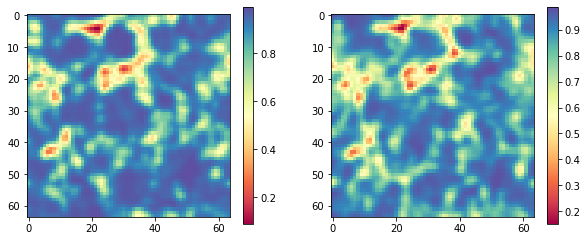

In [36]:
i=0
fig = figure(figsize=(10,4))
fig.add_subplot(121)
imshow(ndimage.gaussian_filter(exp(-recon_RSD_tau[0,:,:,i]),1),cmap="Spectral")
colorbar()
fig.add_subplot(122)
imshow(ndimage.gaussian_filter(np.exp(-1*uni.final_tau_RSD[0,:,:,i]),1),cmap="Spectral")
colorbar()

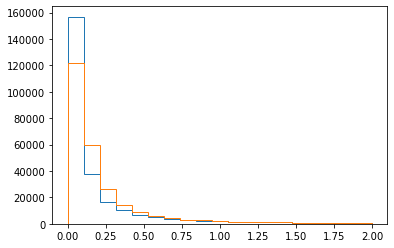

In [9]:
bins=linspace(0,2,20)
hist(recon_RSD_tau.flatten(),bins,histtype='step')
hist(uni.final_tau_RSD.flatten(),bins,histtype='step')
show()

### Wiener filter (without gravitational evolution)

Let N be the noise covariance, $S_m$ be the smoothing operator, s is the reconstructed flux field, d is the data, and R is the mapping from flux field to data space. The quantity to be optimized:
$$\chi^2 = (S_m(s) - s)^2 + (R(s) - d)^T N^{-1} (R(s)-d)$$


In [10]:
def loss(inputs, data, inverse_covar):
    
    residual = tf.subtract(inputs, data)
    a = tf.sparse.sparse_dense_matmul(inverse_covar, residual,adjoint_b=True)
    value = tf.matmul(residual,a)
    return value

In [41]:
tf.reset_default_graph()
lya=mock_lya

xx = tf.placeholder(tf.float32, shape=(1, n, n, n)) #Starting Point

initial=tf.Variable(zeros(shape=(1,n,n,n)),dtype='float32',trainable=True)

RSD_tau = tf.multiply(initial,1)
flux_s = K.exp(-RSD_tau)
Rs = tf.placeholder(tf.float64, shape = [1], name='smoothing')
sum_op = reduce_sum_det

Rsm = tf.multiply(Rs, 1)
kvec = fftk((n,n,n), symmetric=False)
kmesh = sum((kk)**2 for kk in kvec)**0.5
pkmesh = ipklin(kmesh)

yy_lya = tf.placeholder(tf.float32, [lya.skewers_fin.shape[0]]) #lya flux
flux_val = flowpm.cic_readout(flux_s,np.array(lya.skewers_fin,dtype=np.float32).reshape(1,-1,3))

#The chi^2 we want to minimize
obj_fun = loss(flux_val,yy_lya,lya.inverse_covar)+sum_op(tf.square(tf.subtract(flux_s,smoothing(flux_s,Rsm,kmesh,n))))

G:\Anaconda\envs\Tensorflow_1\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  from ipykernel import kernelapp as app


In [42]:
sess = tf.Session()
sess.run(tf.compat.v1.global_variables_initializer())
sess.run(RSD_tau)

annel_steps = [3,2,1,0]
maxiter = [100,100,100,100]
time_start = time.time()
for nn,r0 in enumerate(annel_steps):
    opt = ScipyOptimizerInterface(obj_fun, var_list=[initial], method='L-BFGS-B',options={'maxiter': maxiter[nn], 'gtol':gtol,'disp': True})
    z = opt.minimize(sess, {yy_lya:lya.vals_observed,Rs:[r0]})
time_end = time.time()
print('Total run time %f'%(time_end-time_start))
recon_RSD_tau2,recon_flux2 = sess.run([ RSD_tau,flux_val],{ yy_lya:lya.vals_observed,Rs:[1]})

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 39024.871094
  Number of iterations: 99
  Number of functions evaluations: 122
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 38522.917969
  Number of iterations: 100
  Number of functions evaluations: 110
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 37292.664062
  Number of iterations: 100
  Number of functions evaluations: 102
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 28125.046875
  Number of iterations: 100
  Number of functions evaluations: 103
Total run time 23.157457


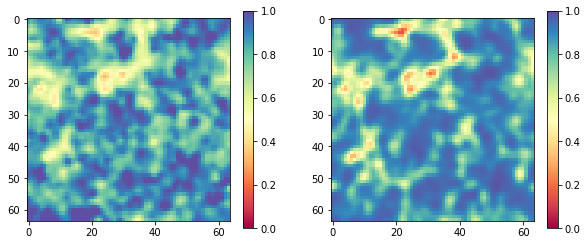

In [43]:
i=0
fig = figure(figsize=(10,4))
fig.add_subplot(121)
imshow(ndimage.gaussian_filter(exp(-recon_RSD_tau2[0,:,:,i]),1),vmin=0,vmax=1,cmap="Spectral")
colorbar()
fig.add_subplot(122)
imshow(ndimage.gaussian_filter(exp(-uni.final_tau_RSD[0,:,:,i]),1),vmin=0,vmax=1,cmap="Spectral")
colorbar()
show()

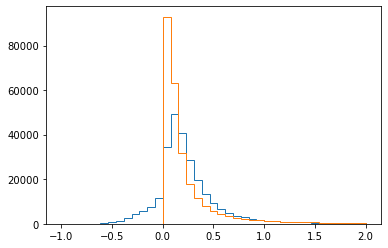

In [44]:
bins=linspace(-1,2,40)
hist(recon_RSD_tau2.flatten(),bins,histtype='step')
hist(uni.final_tau_RSD.flatten(),bins,histtype='step')
show()

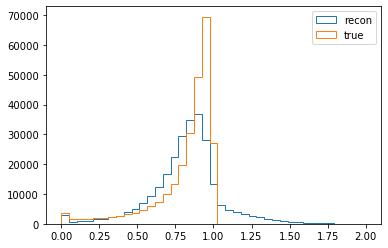

In [45]:
bins=linspace(0,2,40)
hist(exp(-recon_RSD_tau2).flatten(),bins,histtype='step',label='recon')
hist(exp(-uni.final_tau_RSD).flatten(),bins,histtype='step',label='true')
legend()
show()